## Study of the evolution of snowfall in the catalan Pyrenees

We will study the trend experienced in the snowfall pattern, from data of the daily evolution of the snow depth registered in various points in the catalan Pyrinees along the last decades. The main objective is then to study whether or not the total acumulated snowfall is decreasing.

The snow depth data is obtained from the catalan meteorological service (Servei Meteorològic de Catalunya) and the catalan geological and cartographic institute (Institut Geològic i Cartogràfic de Catalunya). The data registers the snow depth with a daily frequency, from November 1st to May 31st. In case of very premature snowfall, which has therefore not been registered, it will be assumed that the initial snowdepth is due to a single snowfall event.

In [1]:
# basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# libraries containing the developed classes and functions
import snowSeason as ss
import functions as f

### Reanalysis

Due to the usually remoteness and harsh climatological conditions of the meteorological stations where the measurements are carried on, there might be days in which the data is incorrectly registered, or even no registered at all some days, such that the raw data contains invalid values of the snow depths. As we are interested in studying the snowfall episodes, this fact can yield an overestimation of it.

In order to interpolate the missing data, we consider a situation in which there are no additional snowfall episodes and hence that the snow depth steadily decreases. As a thermodynamic first order approximation, we assume the snow depth $D(t)$ to decrease at a rate inversely proportional to the current depth:
\begin{equation}
\frac{dD(t)}{dt} = -\frac{\kappa}{D(t)},
\end{equation}
with $\kappa$ a strictly positive constant defining the melting rate. This equation can be integrated to yield
\begin{equation}  
D(t) = \sqrt{D_0^2 - 2\kappa t},
\end{equation}
where $D_0$ is the starting depth. The melting rate is thus defined as $\kappa = (D_0^2 - D_f^2) / 2\Delta t$, where $\Delta t$ is the time spent for the snow depth to evolve from $D_0$ to $D_f < D_0$. The rate $\kappa$ will obviously depend on the instantaneous meteorological conditions, as well as on the microclimate characterising each measurement station, but we will assume, for the sake of simplicity, two different and constant values depending on whether the measurements are taken within the first part of the season (initial 70% of the days) or in the second part (last 30% of the days), as the temperatures tend to rapidly rise in the later. By inspection of various cases, we set a value of $\kappa = 150$ for the first part and $\kappa=400$ for the second one.

By applying this correction to the measured data we obtain much realistic evolutions:

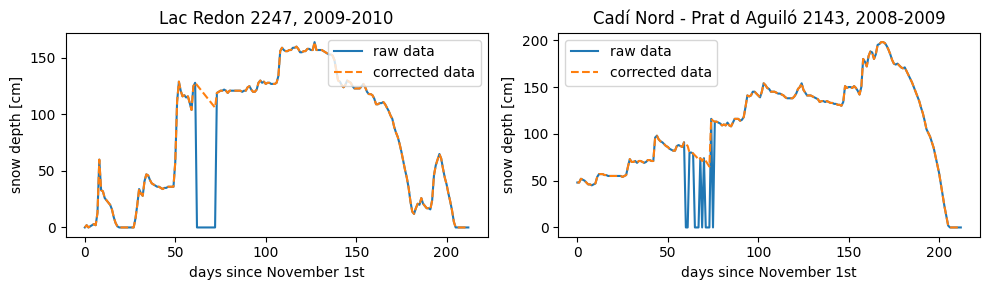

In [2]:
# read data for Lac Redon station's 2009-2010 season's snow depth
data = pd.read_excel('data/Lac Redon 2247.xlsx')
seasonData = data['09-10']
snowDepth_LacRedon = np.zeros(len(seasonData)) 
for i in range(len(seasonData)):
    if (type(seasonData[i]) != str):   # data is read if it's a valid value, otherwise it's set to 0
        if not (np.isnan(seasonData[i])):
            snowDepth_LacRedon[i] = seasonData[i]

# read data for Prat d'Aquiló station's 2008-2009 season's snow depth
data = pd.read_excel('data/Cadí Nord - Prat d Aguiló 2143.xlsx')
seasonData = data['08-09']
snowDepth_PratdAguilo = np.zeros(len(seasonData)) 
for i in range(len(seasonData)):
    if (type(seasonData[i]) != str):   # data is read if it's a valid value, otherwise it's set to 0
        if not (np.isnan(seasonData[i])):
            snowDepth_PratdAguilo[i] = seasonData[i]


plt.figure(figsize = [10, 3])

plt.subplot(1, 2, 1)
plt.plot(snowDepth_LacRedon, label = 'raw data')
snowDepth_LacRedon = f.correctSnowDepth(snowDepth_LacRedon)    # correct data
plt.plot(snowDepth_LacRedon, '--', label = 'corrected data')
plt.ylabel('snow depth [cm]')
plt.xlabel('days since November 1st')
plt.legend(loc = 'upper right')
plt.title('Lac Redon 2247, 2009-2010')

plt.subplot(1, 2, 2)
plt.plot(snowDepth_PratdAguilo, label = 'raw data')
snowDepth_PratdAguilo = f.correctSnowDepth(snowDepth_PratdAguilo)    # correct data
plt.plot(snowDepth_PratdAguilo, '--', label = 'corrected data')
plt.ylabel('snow depth [cm]')
plt.xlabel('days since November 1st')
plt.legend()
plt.title('Cadí Nord - Prat d Aguiló 2143, 2008-2009')

plt.tight_layout()
plt.show()

Fig. 1) Time evolution of the snow depth in Lac Redon 2247 and Cadí Nord - Prat d'Aguiló 2143. Raw data (blue) and corrected data (orange). We observe how the rapid decrease and increase of the snow depth in both cases was clearly non-realistic, and would have yielded an overestimation of the snowfall.

### Read and correct data

In [3]:
stations = ['Boí 2535', 'Bonaigua 2266', 'Cadí Nord - Prat d Aguiló 2143', 'Certascan 2400', 'El Port del Comte 2316',
            'Espot 2519', 'Lac Redon 2247', 'Malniu 2230', 'Núria 1971', 'Pastuira 2000', 'Salòria 2451', 'Sasseuva 2228',
            'Ulldeter 2364', 'Ulldeter 2410']


# run through all stations
stationDic = {}
for station in stations:
    
    # define path to read data from
    path = 'data/' + station + '.xlsx'
    
    # read data corrsponding to the current station
    data = pd.read_excel(path)
    keys = data.keys()

    # read dates
    dates = data[keys[0]]

    # run through all seasons
    seasonDic = {}
    for seasonYear in keys[1:]:
        seasonData = data[seasonYear]

        # read snow depths for each season
        snowDepth = np.zeros(len(seasonData)) 
        for i in range(len(seasonData)):
            if (type(seasonData[i]) != str):
                if not (np.isnan(seasonData[i])):
                    snowDepth[i] = seasonData[i]


        # correct snow depths
        snowDepth = f.correctSnowDepth(snowDepth)

        # store season in a dictionary, with years as key
        seasonDic[seasonYear] = ss.snowSeason(snowDepth, dates)
        
    
    # store seasonDic in a dictionary, with station as key
    stationDic[station] = seasonDic

### Total accumulated snowfall

We will first measure the Total Accumulated SnowFall (TASF) along each season and in each place. To do so, we identify the periods in which the snow depth is increasing and we add them up. 

In order to measure how the snowfall has evolved along the years, we compute the TASF's trend in each meteorological station.

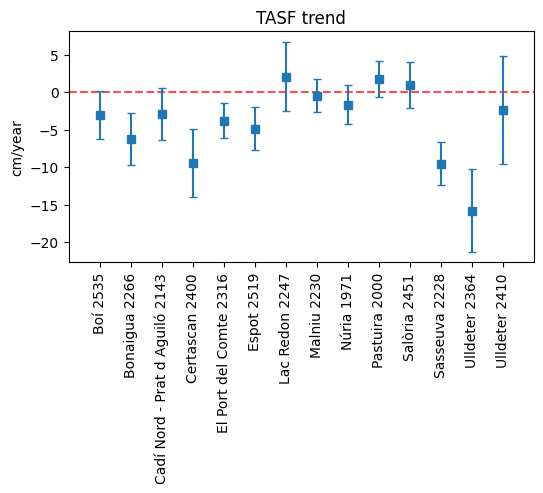

In [4]:
trends = []
sigmas = []
for station in stations:
    seasonDic = stationDic[station]
    seasons = seasonDic.keys()
    
    # store values of total accumulated snow for each station's season
    totalAccumulatedSnow = []
    for season in seasons:
        totalAccumulatedSnow.append(seasonDic[season].totalAccumulatedSnow)
        
        
    # fit with a linear function in order to compute trend
    popt, pcov = curve_fit(f.linearFit, np.arange(len(seasons)), totalAccumulatedSnow)
    fit = f.linearFit(np.arange(len(seasons)), *popt)
    trend = popt[0]
    sigma = pcov[0][0] ** .5
    
    # store trend and its one sigma significance interval, obtained from the covariance matrix
    trends.append(trend)
    sigmas.append(sigma)



# plot the TASF's trend for each station, with the errorbars representing a 1 sigma confidence interval
plt.figure(figsize = [6, 3])

plt.plot([-1, len(trends)], [0, 0], '--r', alpha = .7)
plt.errorbar(stations, trends, yerr = sigmas, fmt = 's', capsize = 3)
plt.xticks(rotation = 90)

plt.xlim([-1, len(trends)])
plt.title('TASF trend')
plt.ylabel('cm/year')
plt.show()

The TASF's trend is negative for the majority of the stations. Let us compute the average over stations, weighted by the amount of years for which there is available data.

In [5]:
maxTrend = 0
minTrend = 0
meanTrend = 0

totalWeight = 0
for i in range(len(trends)):

    station = stations[i]
    weight = len(stationDic[station].keys())
    
    maxTrend = maxTrend + (trends[i] + sigmas[i]) * weight
    minTrend = minTrend + (trends[i] - sigmas[i]) * weight
    meanTrend = meanTrend + trends[i] * weight
    totalWeight = totalWeight + weight
    
maxTrend = round(maxTrend / totalWeight, 1)
minTrend = round(minTrend / totalWeight, 1)
meanTrend = round(meanTrend / totalWeight, 1)

print('mean trend averaged over stations :', meanTrend, 'cm/year')
print('minimum trend averaged over stations within 1 sigma :', minTrend, 'cm/year')
print('maximum trend averaged over stations within 1 sigma :', maxTrend, 'cm/year')

mean trend averaged over stations : -3.6 cm/year
minimum trend averaged over stations within 1 sigma : -7.0 cm/year
maximum trend averaged over stations within 1 sigma : -0.3 cm/year


The weighted average trend is $r=-3.6 \pm 3.3$ centimeters per year (rounded to the first decimal). Even though the uncertainty is relatively high, the trend rate is negative even in the most optimistic scenario.

Given the fact that the studied stations are placed within a relatively small geographic region (the catalan Pyrenees), by considering high enough altitudes such that each valley's microclimates can be neglected, we can assume the mean temperature to be a function of the height only. Contrarily, htough, by ploting the TASF's trend as a function of the height of the corresponding station we observe that there is not a clear correlation between them:

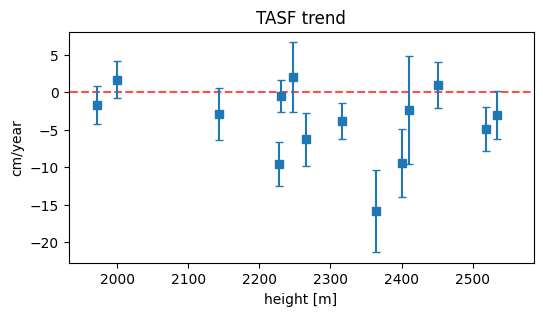

In [6]:
heights = []
for station in stations:
    heights.append(int(station[-4:]))

plt.figure(figsize = [6, 3])

plt.plot([.95 * min(heights), 1.05 * max(heights)], [0, 0], '--r', alpha = .7)
plt.errorbar(heights, trends, yerr = sigmas, fmt = 's', capsize = 3)

plt.xlim([.98 * min(heights), 1.02 * max(heights)])
plt.title('TASF trend')
plt.ylabel('cm/year')
plt.xlabel('height [m]')
plt.show()

and thus we can coclude that the decrease in the TASF is not only due to an increase in the temperatures (such that it rains more and snows less), but also hints in the direction of a decrease in the total amount of precipitation.

### Distribution of the snowfall episodes by intensity

We define four different categories, that discriminate the snowfall episodes by their intensities:
- light snowfalls: between 0 and 5 cm of new snow
- moderate snowfalls: between 5 and 20 cm of new snow
- heavy snowfall: between 20 and 50 cm of new snow
- extreme snowfall: more than 50 cm of new snow

These levels approximately represent the 60%, 25%, 10% and 5% of the snowfalls in the area, respectivelly.

We compute, for each station, the statistical frequency of each intensity level along the years, and their corresponding trends

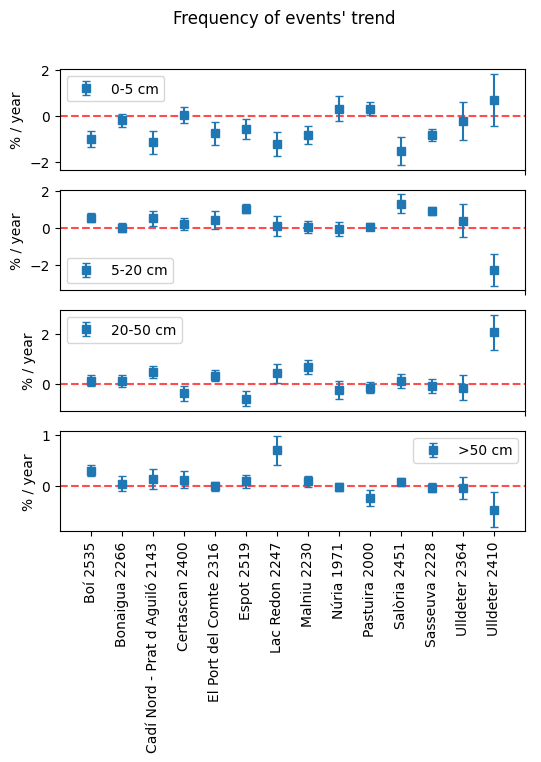

In [7]:
# define intensity intervals
labels = ['0-5 cm', '5-20 cm', '20-50 cm', '>50 cm']
bins = np.array([0, 5, 20, 50, 160])


trends = []
sigmas = []
# run through all stations
for station in stations:
    seasonDic = stationDic[station]
    seasons = seasonDic.keys()

    eventFrequency = []
    # run through all seasons
    for season in seasons:
        
        snowFalls = seasonDic[season].snowFalls
        newSnow = []
        # detect all snowFalls in the specified season and station
        for sf in snowFalls:
            newSnow.append(sf.newSnow)
            
        # count how many events fall within the specified range, and compute
        # its frequency (in %) from it
        eventFrequency.append(100 * f.countsInRange(newSnow, bins, normalizationCriteria = 'frequency'))

    eventFrequency = np.array(eventFrequency)
    
    stationTrends = []
    stationSigmas = []
    for i in range(len(bins) - 1):
        # fit with a linear function in order to compute trend
        popt, pcov = curve_fit(f.linearFit, np.arange(len(seasons)), eventFrequency[:, i])
        fit = f.linearFit(np.arange(len(seasons)), *popt)
        trend = popt[0]
        sigma = pcov[0][0] ** .5
        
        # store trend and its one sigma significance interval, obtained from the covariance matrix
        stationTrends.append(trend)
        stationSigmas.append(sigma)
        
    trends.append(stationTrends)
    sigmas.append(stationSigmas)
    
trends = np.array(trends)
sigmas = np.array(sigmas)


# plot the trend of the frequency of each intensity level
plt.figure(figsize = [6, 6])
plt.suptitle('Frequency of events\' trend')
for i in range(len(labels)):
    plt.subplot(4, 1, i + 1)
    plt.plot([-1, len(trends[:, i])], [0, 0], '--r', alpha = .7)
    plt.errorbar(stations, trends[:, i], yerr = sigmas[:, i], fmt = 's', capsize = 3, label = labels[i])
    plt.xticks(rotation = 90)

    plt.xlim([-1, len(trends[:, i])])
    
    plt.legend()

    plt.ylabel('% / year')
    if (i != len(labels) - 1):
        plt.xticks(' ')

plt.show()

And, as before, we compute their average weighted by the number of years for which there is available data:

In [8]:
for i in range(len(labels)):
    trends_i = trends[:, i]
    sigmas_i = sigmas[:, i]
    
    maxTrend = 0
    minTrend = 0
    meanTrend = 0

    totalWeight = 0
    for j in range(len(trends_i)):
        station = stations[i]
        weight = len(stationDic[station].keys())

        maxTrend = maxTrend + (trends_i[j] + sigmas_i[j]) * weight
        minTrend = minTrend + (trends_i[j] - sigmas_i[j]) * weight
        meanTrend = meanTrend + trends_i[j] * weight
        totalWeight = totalWeight + weight
        
    maxTrend = round(maxTrend / totalWeight, 1)
    minTrend = round(minTrend / totalWeight, 1)
    meanTrend = round(meanTrend / totalWeight, 1)
    
    print('mean trend averaged over stations for', labels[i], 'snowfalls:', meanTrend, '%/year')
    print('minimum trend averaged over stations within 1 sigma for', labels[i], 'snowfalls:', minTrend, '%/year')
    print('maximum trend averaged over stations within 1 sigma for', labels[i], 'snowfalls:', maxTrend, '%/year')
    print(' ')

mean trend averaged over stations for 0-5 cm snowfalls: -0.5 %/year
minimum trend averaged over stations within 1 sigma for 0-5 cm snowfalls: -1.0 %/year
maximum trend averaged over stations within 1 sigma for 0-5 cm snowfalls: 0.0 %/year
 
mean trend averaged over stations for 5-20 cm snowfalls: 0.2 %/year
minimum trend averaged over stations within 1 sigma for 5-20 cm snowfalls: -0.2 %/year
maximum trend averaged over stations within 1 sigma for 5-20 cm snowfalls: 0.7 %/year
 
mean trend averaged over stations for 20-50 cm snowfalls: 0.2 %/year
minimum trend averaged over stations within 1 sigma for 20-50 cm snowfalls: -0.1 %/year
maximum trend averaged over stations within 1 sigma for 20-50 cm snowfalls: 0.5 %/year
 
mean trend averaged over stations for >50 cm snowfalls: 0.0 %/year
minimum trend averaged over stations within 1 sigma for >50 cm snowfalls: -0.1 %/year
maximum trend averaged over stations within 1 sigma for >50 cm snowfalls: 0.2 %/year
 


Such that we obtain the following trends:

$r_{light} = -0.5 \pm 0.5$ % per year

$r_{moderate} = 0.2 \pm 0.4$ % per year

$r_{heavy} = 0.2 \pm 0.3$ % per year

$r_{extreme} = 0.0 \pm 0.1$ % per year

We observe that the mean values of these tendencies are positive for moderate and heavy events, while negative for light events and zero for extreme ones, and thus that the frequency of light events is reduced in favour of heavier ones. The confidence in these results is, nevertheless, lower than in the previous ones, as noted by the standard deviations.